In [7]:
import openeo
from matplotlib import pyplot as plt
import rasterio.plot
import io
import tarfile
import numpy as np
import glob
import re
import os
import xarray as xr
import torch

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [8]:
main_dir='/cloud/skogsstyrelsen_1c_attempt_2/'
directories=os.listdir(main_dir)
directories

['0316fae7-d2c1-40b7-b6b1-572503129723',
 '124c5465-43c0-4b8b-a624-f78a237a4a55',
 '307f0810-6f13-4bde-b88c-b9eaf8ce5d25',
 '3b208f65-cf77-4349-9708-a9a4fc06f5d8',
 '3b9b0586-98ce-4603-bd8b-a81423647b70',
 '43ab4c4c-310b-44ae-9548-e09017656537',
 '48948379-d614-4be8-a319-8174a15875e0',
 '5f22ce6c-8d7d-438f-ab05-bd043a708e82',
 '6061d236-faf2-4e6f-83cb-3fdda8451144',
 '68dbadbe-22e8-4839-afa9-b6dbe8331b22',
 '783b6f31-d468-4a86-802d-41b2c8df9bc2',
 '7e2fa848-3d2a-4eb4-99b6-4ffd36a8fb46',
 '866209bc-5ef4-4917-8759-21be697c4fc8',
 '88a26a3d-7ac4-4342-95ed-e630bc7122d0',
 '8ef56cc8-841a-41db-87e7-08c2a41b381c',
 '9eb96d40-6ca4-43b6-863e-f75211c1bfe0',
 '9fd0096b-b3d8-499f-84c1-89e69cc0a743',
 'b8c67bde-8f24-4102-bd11-7893e64070d6',
 'bcfbcb12-8d19-4a50-88fb-d57f847b6943',
 'c5382068-a8ab-40c7-a638-92a14fe493bc',
 'e44bba51-a024-4890-9758-bcf82bde1e98',
 'f3d18472-a865-459b-a5d7-a4cda0d1ce30']

In [9]:
from cot_train.utils import StatCollector, MLP5, mlp_inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
model_load_paths=['cot_model/0/model_it_2000000','cot_model/1/model_it_2000000',
                  'cot_model/2/model_it_2000000','cot_model/3/model_it_2000000',
                  'cot_model/4/model_it_2000000']

input_dim = 13
output_dim = 1

models_cot=[]
for model_path in model_load_paths:
    model_cot = MLP5(input_dim, output_dim, apply_relu=True)
    model_cot.load_state_dict(torch.load(model_path, map_location=device))
    model_cot.to(device)
    models_cot.append(model_cot)

means=[0.534958,0.538317,0.532992,0.629737,0.826885,0.859306,0.803385,0.880321,0.408178,0.066565,0.428241,0.301306,58.076266]
stds=[0.218962,0.188747,0.236514,0.185751,0.169492,0.170012,0.162448,0.171793,0.237684,0.096908,0.309903,0.202586,15.602082]


In [30]:
pairs_all=[]
pairs_all_ix=[]
ims_all=[]
cots_all=[]
temporals_all=[]
divide=10000
for i,dir in enumerate(directories):
    print('dir '+str(i)+' of '+str(len(directories)))
    pairs=[]
    pairs_ix=[]
    #Get temporals for directory
    temporals_t=glob.glob(main_dir+dir+'/*.nc')
    temporals=[]
    for t in temporals_t:
        temporals.append(t.split('/')[-1].split('.')[0])
    temporals_all.append(temporals)
    ims=[]
    cots=[]
    for j,temp in enumerate(temporals):
        print('     Temporal '+str(j)+' of '+str(len(temporals)))

        loaded_data = xr.open_dataset(main_dir+dir+'/'+temp+'.nc', engine='netcdf4', decode_times=True)
        nodata = loaded_data.attrs.get("nodata", None)
        loaded_data = loaded_data.where(loaded_data != nodata, np.nan)
        variables=loaded_data.variables

        if int(temp.split('-')[0])>=2022: #Add offset to all data past 2022
            offset=-1000
        else:
            offset=0
        ## Get bands ##
        b02=(np.clip(variables['b02'].data[0,:,:],offset,10000)+offset)/divide
        b03=(np.clip(variables['b03'].data[0,:,:],offset,10000)+offset)/divide
        b04=(np.clip(variables['b04'].data[0,:,:],offset,10000)+offset)/divide
        b05=(np.clip(variables['b05'].data[0,:,:],offset,10000)+offset)/divide
        b06=(np.clip(variables['b06'].data[0,:,:],offset,10000)+offset)/divide
        b07=(np.clip(variables['b07'].data[0,:,:],offset,10000)+offset)/divide
        b08=(np.clip(variables['b08'].data[0,:,:],offset,10000)+offset)/divide
        b8a=(np.clip(variables['b8a'].data[0,:,:],offset,10000)+offset)/divide
        b09=(np.clip(variables['b09'].data[0,:,:],offset,10000)+offset)/divide
        b10=(np.clip(variables['b10'].data[0,:,:],offset,10000)+offset)/divide
        b11=(np.clip(variables['b11'].data[0,:,:],offset,10000)+offset)/divide
        b12=(np.clip(variables['b12'].data[0,:,:],offset,10000)+offset)/divide
        sun_z=variables['sun_zenith']

        ## Save image ##
        im=np.zeros((np.shape(b03)[0],np.shape(b03)[1],13))
        im[:,:,0]=b02
        im[:,:,1]=b03
        im[:,:,2]=b04
        im[:,:,3]=b05
        im[:,:,4]=b06
        im[:,:,5]=b07
        im[:,:,6]=b08
        im[:,:,7]=b8a
        im[:,:,8]=b09
        im[:,:,9]=b10
        im[:,:,10]=b11
        im[:,:,11]=b12
        im[:,:,12]=sun_z


        #Reshape and prepare COT estimation
        im_shape=np.shape(im)
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
        for i in range(im_shape[2]):
            im_cloud_r[:,i]=np.reshape(im[:,:,i],im_shape[0]*im_shape[1])
        
        #COT estimation
        inputs = (im_cloud_r - means) / stds
        image_input_tens=torch.Tensor(inputs).to(device)
        #image_pred_cot=model_cot(image_input_tens).cpu().data.numpy()*50
        preds = 0
        for model_cot in models_cot:
            curr_preds=model_cot(image_input_tens)/len(models_cot)
            preds=preds+curr_preds
        pred_cot=preds.cpu().data.numpy() #unnormalise
        ## Reshape back
        im_pred_cot=np.reshape(pred_cot,im_shape[0:2])*50
        t_is_cloud = 0.025*50 # From Alex
        t_thin_cloud = 0.015*50 # From Alex
        im_pred_cot_t=im_pred_cot.copy()
        im_pred_cot_t[im_pred_cot_t<t_thin_cloud]=0
        im_pred_cot_t[(im_pred_cot_t>t_thin_cloud)&(im_pred_cot_t<t_is_cloud)]=1
        im_pred_cot_t[im_pred_cot_t>t_is_cloud]=2

        im_pred_cot_t_r=np.reshape(im_pred_cot_t,im_shape[0]*im_shape[1])
        cots.append(im_pred_cot_t_r)
        im_wcot=np.zeros((im_shape[0],im_shape[1],im_shape[2]+1))
        im_wcot[:,:,0:13]=im
        im_wcot[:,:,13]=im_pred_cot_t
        ims.append(im_wcot)
    
    for j,cot in enumerate(cots):
        frac_cloud=np.sum(cot>0)/np.size(cot)
        if frac_cloud>=0.1: #If more than 5 % clouds
            if j<(len(cots)-1):
                if np.sum(cots[j+1]>1)/np.size(cots[j+1])<0.005: #If no cloud in neighbouring image
                    pair=(temporals[j+1],temporals[j])
                    pair_ix=(j+1,j)
                    pairs.append(pair)
                    pairs_ix.append(pair_ix)
            elif j>0:
                if np.sum(cots[j-1]>0)/np.size(cots[j-1])<0.005: #If no cloud in neighbouring image
                    pair=(temporals[j-1],temporals[j])
                    pair_ix=(j-1,j)
                    pairs.append(pair)
                    pairs_ix.append(pair_ix)
    pairs_all.append(pairs)
    pairs_all_ix.append(pairs_ix)
    ims_all.append(ims)

dir 0 of 22
     Temporal 0 of 13
     Temporal 1 of 13
     Temporal 2 of 13
     Temporal 3 of 13
     Temporal 4 of 13
     Temporal 5 of 13
     Temporal 6 of 13
     Temporal 7 of 13
     Temporal 8 of 13
     Temporal 9 of 13
     Temporal 10 of 13
     Temporal 11 of 13
     Temporal 12 of 13
dir 1 of 22
     Temporal 0 of 20
     Temporal 1 of 20
     Temporal 2 of 20
     Temporal 3 of 20
     Temporal 4 of 20
     Temporal 5 of 20
     Temporal 6 of 20
     Temporal 7 of 20
     Temporal 8 of 20
     Temporal 9 of 20
     Temporal 10 of 20
     Temporal 11 of 20
     Temporal 12 of 20
     Temporal 13 of 20
     Temporal 14 of 20
     Temporal 15 of 20
     Temporal 16 of 20
     Temporal 17 of 20
     Temporal 18 of 20
     Temporal 19 of 20
dir 2 of 22
     Temporal 0 of 18
     Temporal 1 of 18
     Temporal 2 of 18
     Temporal 3 of 18
     Temporal 4 of 18
     Temporal 5 of 18
     Temporal 6 of 18
     Temporal 7 of 18
     Temporal 8 of 18
     Temporal 9 of 18
     

In [31]:
for i,pairs in enumerate(pairs_all):
    for j,pair in enumerate(pairs):
        print(pair)
        print(pairs_all_ix[i][j])
        

('2023-08-29', '2023-07-23')
(13, 12)
('2023-07-20', '2023-07-08')
(18, 17)
('2023-04-16', '2023-04-03')
(9, 8)
('2018-08-27', '2018-08-25')
(15, 14)
('2018-09-06', '2018-09-04')
(20, 19)
('2021-08-12', '2021-08-11')
(123, 122)
('2023-06-15', '2023-06-05')
(6, 5)
('2023-07-10', '2023-08-24')
(18, 19)
('2023-04-16', '2023-04-03')
(9, 8)
('2023-06-02', '2023-05-31')
(15, 14)


In [32]:
pairs_count=0
for pairs in pairs_all:
    for pair in pairs:
        pairs_count+=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


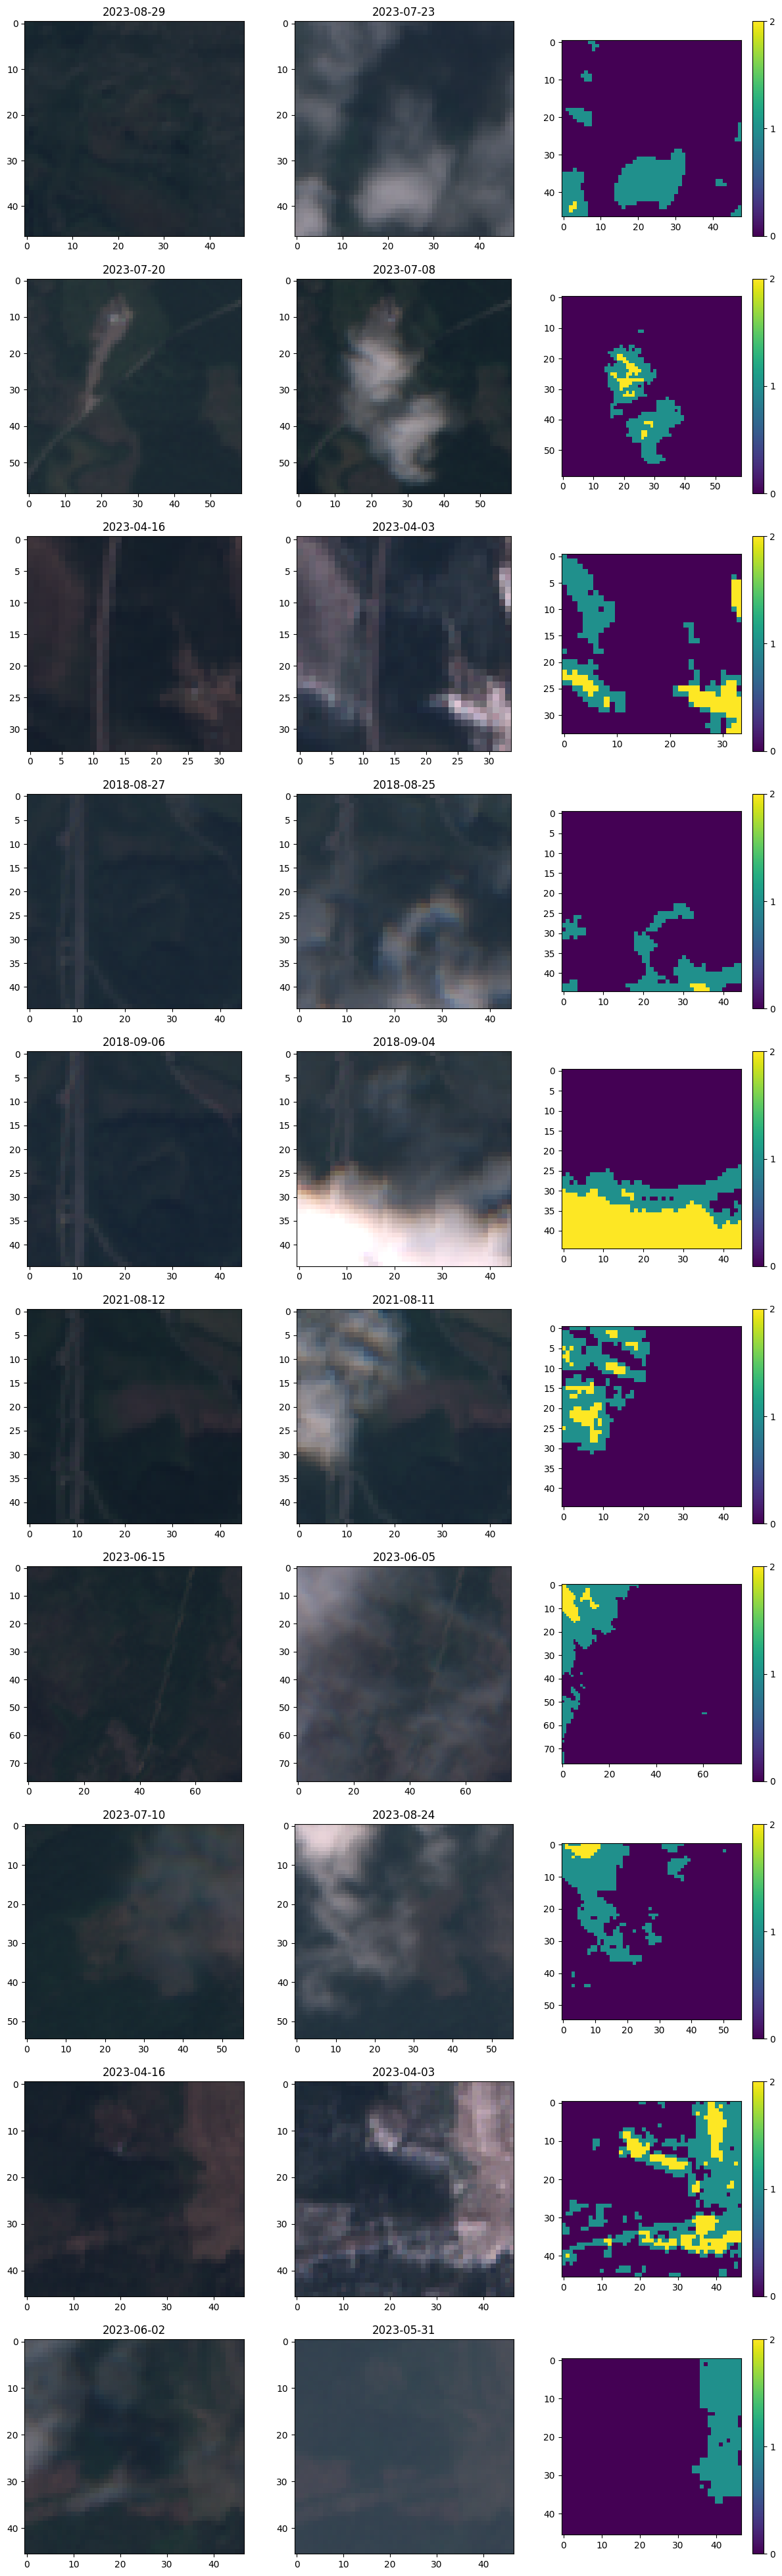

In [44]:
ncols=3
nrows=pairs_count

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]

    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        axs[pair_c,0].imshow(np.flip(im_clear[:,:,0:3],axis=2)*2)
        axs[pair_c,0].set_title(temporals_all[i][pairs_all_ix[i][j][0]])
        axs[pair_c,1].imshow(np.flip(im_cloud[:,:,0:3],axis=2)*2)
        axs[pair_c,1].set_title(temporals_all[i][pairs_all_ix[i][j][1]])
        im_c=axs[pair_c,2].imshow(im_cloud[:,:,-1],vmin=0,vmax=2)
        fig.colorbar(im_c,ax=axs[pair_c,2],ticks=[0,1,2])
        pair_c+=1

In [53]:
main_filepath='pytorch_models/optuna_optimum'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

In [55]:
# Make predictions
ims_preds_all=[]
ims_unc_all=[]
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=[]
    ims_unc=[]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]

        ## Reshape cloudy data
        im_shape=np.shape(im_cloud)
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
        for i in range(im_shape[2]):
            im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

        im_pred_cot_t_r=im_cloud_r[:,-1]
        #One hot encode cot
        cot_one_hot=np.zeros((len(im_pred_cot_t_r),3))
        cot_one_hot[im_pred_cot_t_r==0,0]=1
        cot_one_hot[im_pred_cot_t_r==1,1]=1
        cot_one_hot[im_pred_cot_t_r==2,2]=1

        ## append cot estimation to input data ##
        im_cloud_r_c=np.zeros((np.shape(im_cloud_r)[0],np.shape(im_cloud_r)[1]+2))
        im_cloud_r_c[:,0:13]=im_cloud_r[:,0:13]
        im_cloud_r_c[:,13:16]=cot_one_hot

        ## Make prediction
        for i,model in enumerate(models):
            if i==0:
                pred=model.predict(im_cloud_r_c)
            else:   
                pred=pred+model.predict(im_cloud_r_c)
        pred=pred/len(models)

        ##Reshape back
        index_median=4
        im_shape_pred=(im_shape[0],im_shape[1],12)
        im_pred=np.zeros(im_shape_pred)
        im_unc=np.zeros(im_shape_pred)
        for i in range(im_shape_pred[2]):
            im_pred[:,:,i]=np.reshape(pred[:,i,index_median],im_shape_pred[0:2])
            im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape_pred[0:2])
        ims_preds.append(im_pred)
        ims_unc.append(im_unc)

    ims_preds_all.append(ims_preds)
    ims_unc_all.append(ims_unc)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


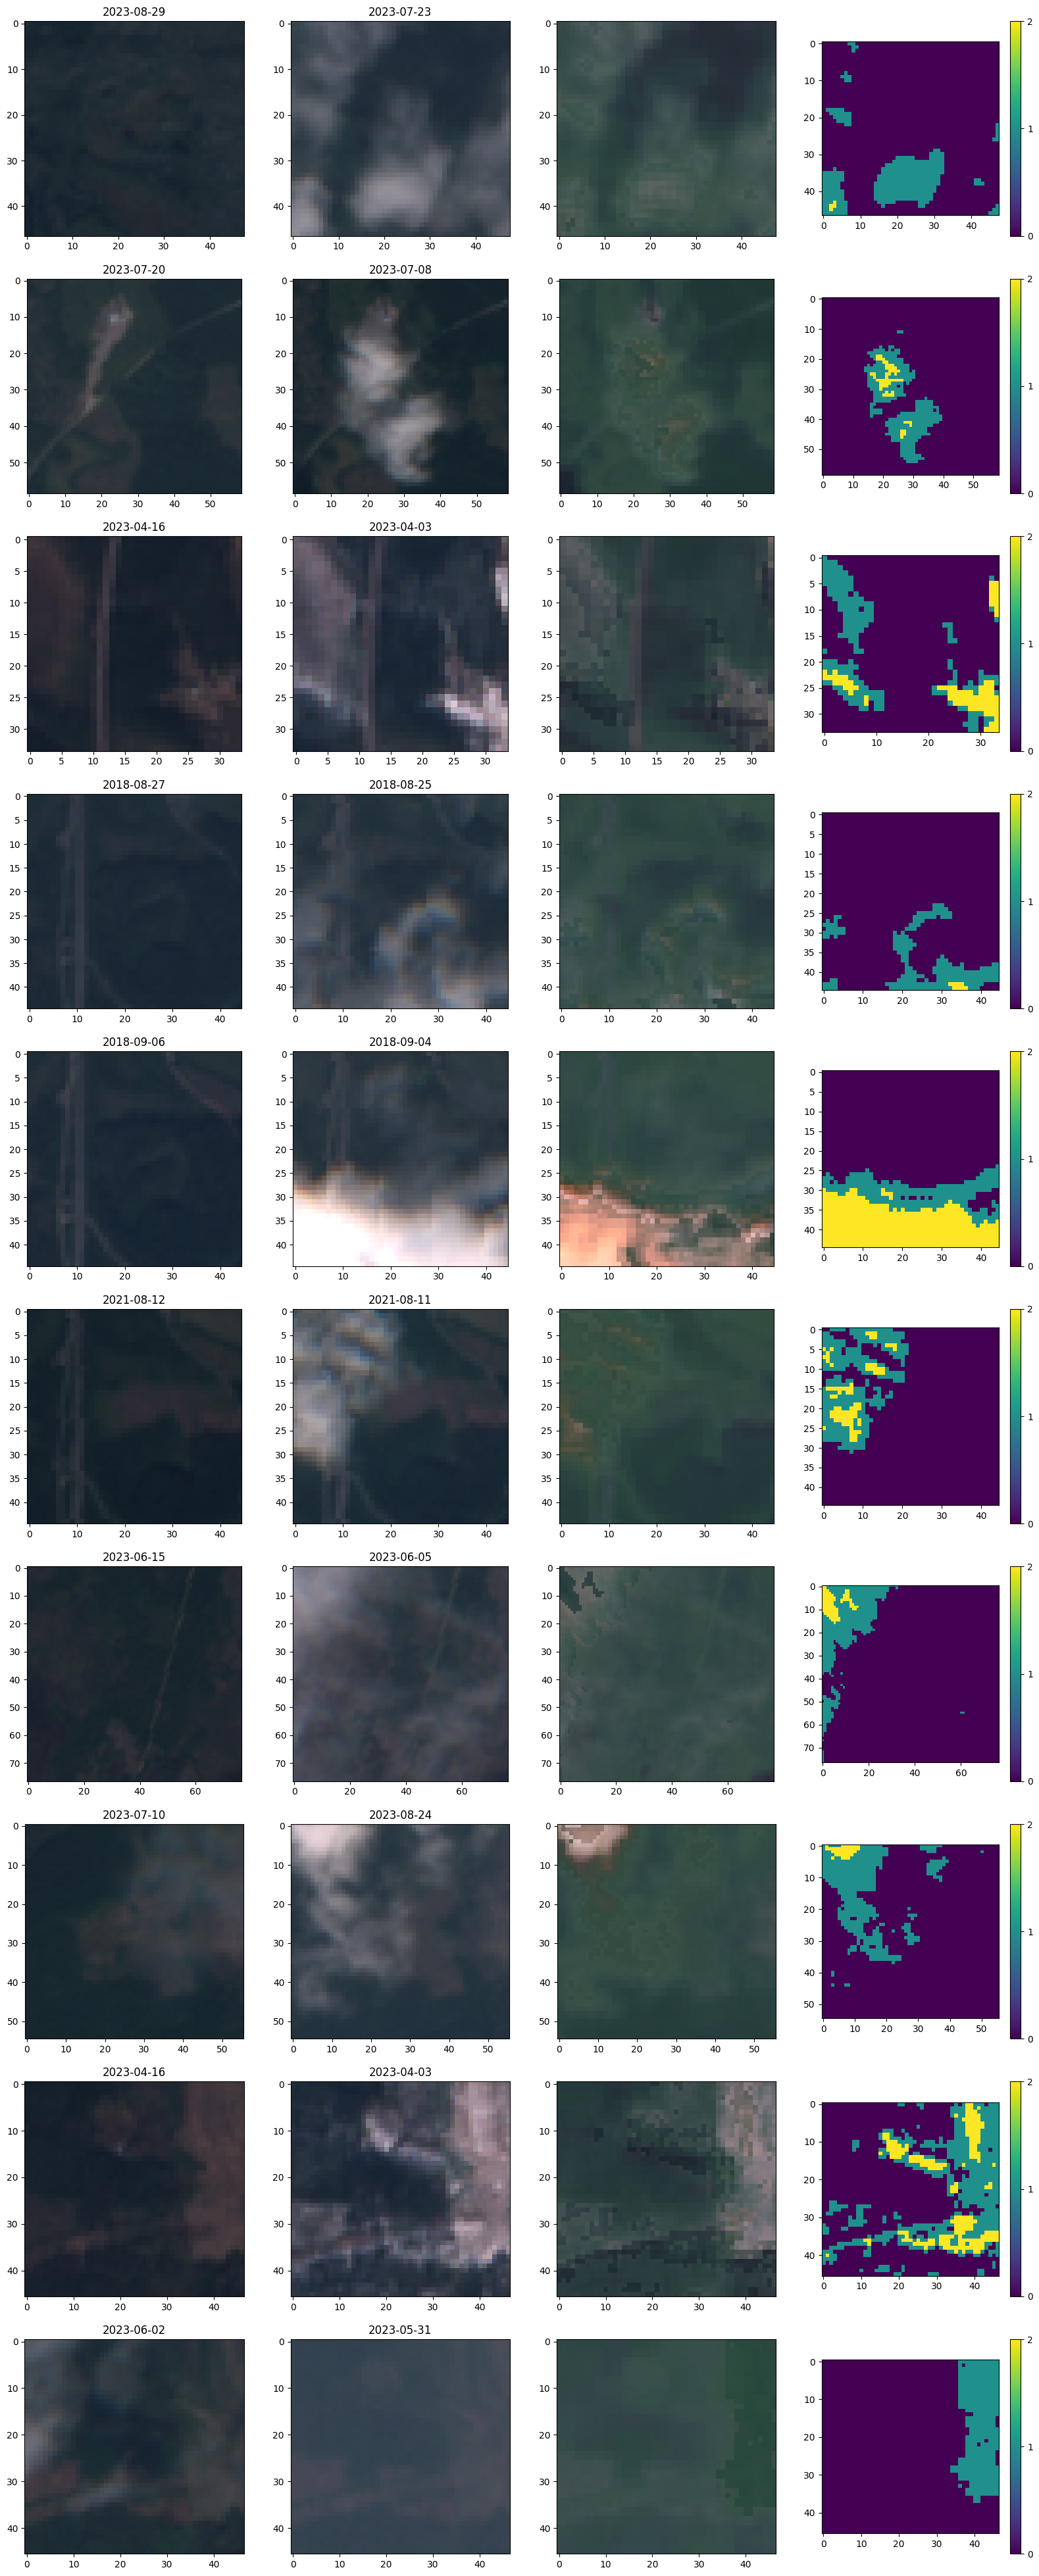

In [56]:
ncols=4
nrows=pairs_count

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=preds[j]
        axs[pair_c,0].imshow(np.flip(im_clear[:,:,0:3],axis=2)*2)
        axs[pair_c,0].set_title(temporals_all[i][pairs_all_ix[i][j][0]])
        axs[pair_c,1].imshow(np.flip(im_cloud[:,:,0:3],axis=2)*2)
        axs[pair_c,1].set_title(temporals_all[i][pairs_all_ix[i][j][1]])
        axs[pair_c,2].imshow(np.flip(im_pred[:,:,0:3],axis=2)*2)

        im_c=axs[pair_c,3].imshow(im_cloud[:,:,-1],vmin=0,vmax=2)
        fig.colorbar(im_c,ax=axs[pair_c,3],ticks=[0,1,2])
        pair_c+=1

## Evaluate predictions

### NMSE

In [68]:
NMSEs_og=np.zeros((pairs_count,12))
NMSEs_pred=np.zeros((pairs_count,12))

p_c=0
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]

        #np.linal.norm() -> Frobenius norm i.e root of the sum of squares
        norm_og=np.linalg.norm(np.square((im_clear[:,:,0:12])-(im_cloud[:,:,0:12])),axis=(0,1))**2
        norm_pred=np.linalg.norm(np.square((im_clear[:,:,0:12])-im_pred[:,:,0:12]),axis=(0,1))**2
        norm_gt=np.linalg.norm(np.square(im_clear[:,:,0:12]),axis=(0,1))**2

        NMSE_og=norm_og/norm_gt
        NMSE_pred=norm_pred/norm_gt

        NMSEs_og[p_c,:]=NMSE_og
        NMSEs_pred[p_c,:]=NMSE_pred
        p_c+=1

mean_NMSE_og=np.mean(NMSEs_og,axis=0)
mean_NMSE_pred=np.mean(NMSEs_pred,axis=0)

In [72]:
for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(mean_NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(mean_NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(mean_NMSE_pred[i]))    

    print(' ')

NMSE before correction, Band 2: 5.017346707085151
NMSE after correction, Band 2: 0.20063251549972722
 
NMSE before correction, Band 3: 14.02759989108414
NMSE after correction, Band 3: 1.4439686112909882
 
NMSE before correction, Band 4: 73.44496095118349
NMSE after correction, Band 4: 18.490191392447958
 
NMSE before correction, Band 5: 20.268767024908467
NMSE after correction, Band 5: 6.432495904280844
 
NMSE before correction, Band 6: 1.1246037972465879
NMSE after correction, Band 6: 0.40980070726665563
 
NMSE before correction, Band 7: 0.6056953673188914
NMSE after correction, Band 7: 0.2571123329931614
 
NMSE before correction, Band 8: 0.4728810700899369
NMSE after correction, Band 8: 0.2803007392862815
 
NMSE before correction, Band 8A: 0.4250422881277663
NMSE after correction, Band 8A: 0.23572973799333644
 
NMSE before correction, Band 9: 8.79938344433528
NMSE after correction, Band 9: 2.4639995777642145
 
NMSE before correction, Band 10: 9.905351116765688
NMSE after correction, 

### Percent from ground truth

In [95]:
in_og=np.zeros((pairs_count,12))
in_pred=np.zeros((pairs_count,12))
p_c=0
percent=0.2
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]
        for k in range(12):
            im_pred_b=im_pred[:,:,k]
            im_cloud_b=im_cloud[:,:,k]
            im_truth_b=im_clear[:,:,k]


            im_in_percent=np.abs(im_pred_b-im_truth_b) <= percent*im_truth_b
            im_in_percent_c=np.abs(im_cloud_b-im_truth_b) <= percent*im_truth_b

            in_og[p_c,k]=np.sum(im_in_percent_c)/np.size(im_in_percent_c)
            in_pred[p_c,k]=np.sum(im_in_percent)/np.size(im_in_percent)

        p_c+=1

mean_in_og=np.mean(in_og,axis=0)
mean_in_pred=np.mean(in_pred,axis=0)

In [96]:
print('Percent pixels within '+str(percent*100)+' percent from ground truth')
print(' ')
for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('OG, Band ' +str(i+2)+': '+str(mean_in_og[i]))
        print('Pred, Band '+str(i+2)+': '+str(mean_in_pred[i]))
    elif i==7:
        print('OG, Band '+str(i+1)+'A: '+str(mean_in_og[i]))
        print('Pred, Band '+str(i+1)+'A: '+str(mean_in_pred[i]))
    else:
        print('OG, Band '+str(i+1)+': '+str(mean_in_og[i]))
        print('Pred, Band '+str(i+1)+': '+str(mean_in_pred[i]))    

    print(' ')

Percent pixels within 20.0 percent from ground truth
 
OG, Band 2: 0.23871438831124703
Pred, Band 2: 0.22719377252313797
 
OG, Band 3: 0.2184598211915124
Pred, Band 3: 0.05592990213258564
 
OG, Band 4: 0.1711115447829434
Pred, Band 4: 0.1707863109132266
 
OG, Band 5: 0.25825841282423917
Pred, Band 5: 0.12123675933263978
 
OG, Band 6: 0.36883271653146255
Pred, Band 6: 0.27325470695402193
 
OG, Band 7: 0.39473225590369104
Pred, Band 7: 0.41669459534447684
 
OG, Band 8: 0.4182289902289208
Pred, Band 8: 0.4688992799736636
 
OG, Band 8A: 0.41809756885467503
Pred, Band 8A: 0.5306510995067877
 
OG, Band 9: 0.4191656234826236
Pred, Band 9: 0.4620300158797523
 
OG, Band 10: 0.309099143260641
Pred, Band 10: 0.13694915669010052
 
OG, Band 11: 0.332551994263815
Pred, Band 11: 0.10131648890166996
 
OG, Band 12: 0.28033447008652373
Pred, Band 12: 0.08114967002361845
 


In [97]:
abs_distances_og=np.zeros((pairs_count,12))
abs_distances_pred=np.zeros((pairs_count,12))

p_c=0
percent=0.2
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]
        for k in range(12):
            im_pred_b=im_pred[:,:,k]
            im_cloud_b=im_cloud[:,:,k]
            im_truth_b=im_clear[:,:,k]

            abs_dist_pred=np.abs(im_pred_b-im_truth_b)
            abs_dist_og=np.abs(im_cloud_b-im_truth_b)

            abs_distances_og[p_c,k]=np.mean(abs_dist_og)
            abs_distances_pred[p_c,k]=np.mean(abs_dist_pred)

        p_c+=1

mean_dist_og=np.mean(abs_distances_og,axis=0)
mean_dist_pred=np.mean(abs_distances_pred,axis=0)

In [98]:
print('Mean Absolute distance to ground truth: ')
print(' ')
for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('OG, Band ' +str(i+2)+': '+str(mean_dist_og[i]))
        print('Pred, Band '+str(i+2)+': '+str(mean_dist_pred[i]))
    elif i==7:
        print('OG, Band '+str(i+1)+'A: '+str(mean_dist_og[i]))
        print('Pred, Band '+str(i+1)+'A: '+str(mean_dist_pred[i]))
    else:
        print('OG, Band '+str(i+1)+': '+str(mean_dist_og[i]))
        print('Pred, Band '+str(i+1)+': '+str(mean_dist_pred[i]))    

    print(' ')

Mean Absolute distance to ground truth: 
 
OG, Band 2: 0.060276874140660464
Pred, Band 2: 0.03892499653370317
 
OG, Band 3: 0.05790421484132191
Pred, Band 3: 0.06065122054450613
 
OG, Band 4: 0.06422544448025322
Pred, Band 4: 0.046112878465040745
 
OG, Band 5: 0.06452394979874423
Pred, Band 5: 0.06462636275682887
 
OG, Band 6: 0.06839113401273586
Pred, Band 6: 0.07128776959224142
 
OG, Band 7: 0.07213785345571916
Pred, Band 7: 0.06656999613462615
 
OG, Band 8: 0.0687642135993771
Pred, Band 8: 0.0621396897405318
 
OG, Band 8A: 0.07558491620870147
Pred, Band 8A: 0.06373908437043159
 
OG, Band 9: 0.029263973434693412
Pred, Band 9: 0.026249946263455632
 
OG, Band 10: 0.0016137357340248349
Pred, Band 10: 0.0015977116473226583
 
OG, Band 11: 0.07044040078390759
Pred, Band 11: 0.14257039813182268
 
OG, Band 12: 0.058840932983566616
Pred, Band 12: 0.10974182928225004
 


In [116]:
clear_array=np.zeros((1,12))
pred_array=np.zeros((1,12))
cloud_array=np.zeros((1,12))
p_c=0
percent=0.2
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]
    ims_preds=ims_preds_all[i]
    for j,pair in enumerate(pairs):
        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]
        im_pred=ims_preds[j]

        im_shape=np.shape(im_pred)
        im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
        for i in range(im_shape[2]):
            im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
            im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
            im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

        clear_array=np.concatenate((clear_array,im_clear_r[:,0:12]))
        pred_array=np.concatenate((pred_array,im_pred_r))
        cloud_array=np.concatenate((cloud_array,im_cloud_r))

        p_c+=1


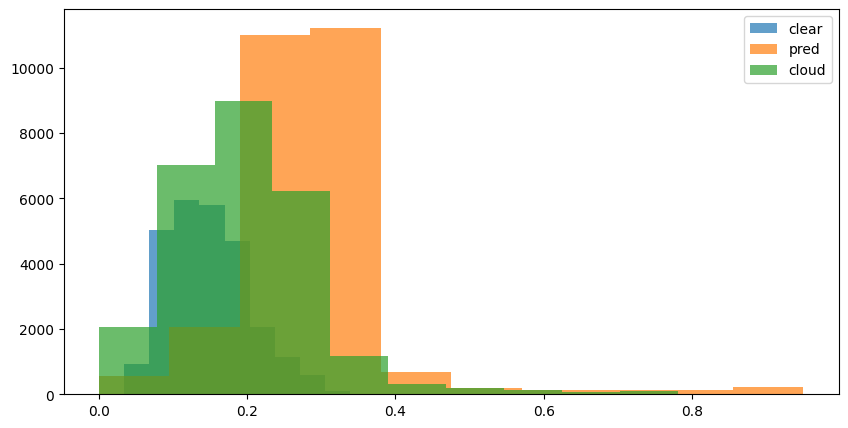

In [118]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.hist(clear_array[:,10],alpha=0.7)
plt.hist(pred_array[:,10],alpha=0.7)
plt.hist(cloud_array[:,10],alpha=0.7)
plt.legend(['clear','pred','cloud'])
plt.show()